<a href="https://colab.research.google.com/github/ygemara/GetCards/blob/master/Copy_of_onboarding_pacing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pacing a Line Item

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

## 1. Introduction

In this notebook, you'll learn about how impressions are distributed, some interesting gotchas, and how to effectively manually pace through the day effectively.

You'll need to run the following cell, which will seed the remainder of the book with useful functions:

In [ ]:
def simulate_line_item(your_bid, auction_type, day_hourly_inventory, night_hourly_inventory, inventory_noise,
                       day_hourly_mean_bid, night_hourly_mean_bid, conversion_rate, revenue_mean, revenue_std,
                       budget, seed=None, diagnostic=True):
    
    if seed is not None: np.random.seed(seed)
    base_inventory = [night_hourly_inventory]*8+[day_hourly_inventory]*14+[night_hourly_inventory]*2
    mean = [night_hourly_mean_bid]*8+[day_hourly_mean_bid]*14+[night_hourly_mean_bid]*2
    inventory = [ inv+np.random.randint(-inventory_noise,inventory_noise) for inv in base_inventory ]
    top_bids = [ ss.norm.rvs(loc=m,scale=3,size=inv) for m,inv in zip(mean,inventory) ]
    top_bids = [ bids[bids>0] for bids in top_bids ]
    if auction_type == 'second-price':
        cost = pd.DataFrame(sum([ [ [hour+1,bid_cost] for bid_cost in top_bids_by_hour[your_bid>top_bids_by_hour]] 
                                  for hour,top_bids_by_hour in enumerate(top_bids) ], []),columns=['hour','cost'])
    elif auction_type == 'first-price':
        cost = pd.DataFrame(sum([ [ [hour+1,bid_cost] for bid_cost in your_bid*np.ones((your_bid>top_bids_by_hour).sum())]
                                  for hour,top_bids_by_hour in enumerate(top_bids) ], []),columns=['hour','cost'])
    within_budget = (cost['cost'].cumsum()<=budget)
    within_budget_hourly = (cost.groupby('hour').sum().reindex(range(1,24+1)).fillna(0).cumsum()<=budget).shift().fillna(True)
    cost = cost[within_budget] # enforce budget constraints
    cost_per_hour = cost.groupby('hour').sum().reindex(range(1,24+1)).fillna(0)
    won_bids = cost.groupby('hour').count().reindex(range(1,24+1)).fillna(0)
    inventory = [ inv if within_budget_hourly.loc[hour+1,'cost'] else 0 for hour,inv in enumerate(inventory) ]
    conversions = ss.binom.rvs(n=won_bids.sum()*1000,p=conversion_rate)
    sales = ss.norm.rvs(loc=revenue_mean,scale=revenue_std,size=conversions)

    imp_col, win_col = sns.color_palette()[:2]
    plt.figure(figsize=(9,6))
    plt.bar(range(1,24+1),inventory,facecolor=imp_col+(.2,),edgecolor=imp_col,width=1,lw=0)
    plt.step(np.arange(0,24+1)+.5,[inventory[0]]+inventory,color=imp_col,lw=1.5)
    plt.bar(range(1,24+1),won_bids['cost'],facecolor=win_col+(.3,),edgecolor=win_col,width=1,lw=0)
    plt.step(np.arange(0,24+1)+.5,[won_bids['cost'].iloc[0]]+won_bids['cost'].tolist(),color=win_col,lw=1.5)
    plt.xlim(.5,24.5)
    plt.xticks(range(1,24+1),range(1,24+1))
    plt.yticks(plt.yticks()[0],[ f"{tick*1000:,.0f}" for tick in plt.yticks()[0] ])
    plt.xlabel("Hour in the Day",fontsize=14)
    plt.ylabel("Bids (Blue) & Wins (Gold)",fontsize=14)
    plt.show()

    if diagnostic:
        print(f"Impressions: {won_bids['cost'].sum()*1000:,.0f}")
        print(f"Budget:      ${budget:,.2f}")
        print(f"Win Percent: {won_bids['cost'].sum()/sum(inventory):.0%}")
        print(f"Spend:       ${cost['cost'].sum():,.2f} ({cost['cost'].sum()/budget:.1%} Spent)")
        print(f"CPM:         ${cost['cost'].sum()/won_bids['cost'].sum():.2f}")
        print("")
        print(f"Conversions: {conversions}")
        print(f"Revenue:     ${sales.sum():,.2f}")
        print(f"CPA:         ${cost['cost'].sum()/conversions:.2f}")
        print(f"ROAS:        {sales.sum()/cost['cost'].sum():.2f}")

## 2. How Impressions are Distributed

_To a first approximation,_ the top bid in any auction is distributed roughly normally. In reality they're a bit more clustered around certain prices, but for a basic understanding this is sufficient. All bids are, of course, above zero dollars:

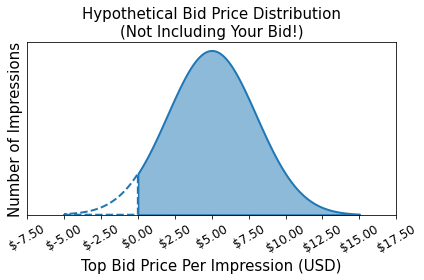

In [ ]:
prices = np.linspace(0,15,50_000)
zero_prices = np.linspace(-5,0,5_000)
top_bid = ss.norm.pdf(prices,loc=5,scale=3)
zero_bid = ss.norm.pdf(zero_prices,loc=5,scale=3)

plt.figure()
plt.title("Hypothetical Bid Price Distribution\n(Not Including Your Bid!)",fontsize=15)
plt.fill_between(prices,0,top_bid,lw=2,edgecolor=sns.color_palette()[0],facecolor=sns.color_palette()[0]+(.5,))
plt.fill_between(zero_prices,0,zero_bid,lw=2,facecolor=(1,1,1),edgecolor=sns.color_palette()[0],linestyle='--')
plt.ylim(0,.14)
plt.yticks([])
plt.xticks(plt.xticks()[0],[ f'${tick:.2f}' for tick in plt.xticks()[0] ],rotation=30,fontsize=12)
plt.ylabel("Number of Impressions",fontsize=15)
plt.xlabel("Top Bid Price Per Impression (USD)",fontsize=15)
plt.tight_layout()
plt.show()

Ergo, the total number of impressions you'll win for any given bid will be sigmoidally distributed. This also implies that the number of impressions you can buy per line item per time interval is _finite_.

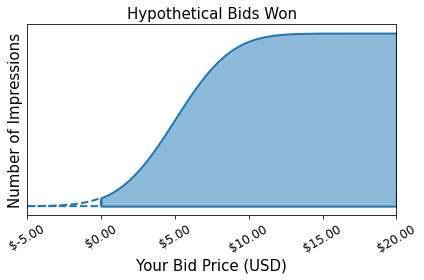

In [ ]:
prices = np.linspace(0,20,50_000)
zero_prices = np.linspace(-5,0,5_000)
won_bids = ss.norm.cdf(prices,loc=5,scale=3)
zero_won_bids = ss.norm.cdf(zero_prices,loc=5,scale=3)

plt.figure()
plt.title("Hypothetical Bids Won",fontsize=15)
plt.fill_between(prices,0,won_bids,lw=2,edgecolor=sns.color_palette()[0],facecolor=sns.color_palette()[0]+(.5,))
plt.fill_between(zero_prices,0,zero_won_bids,lw=2,facecolor=(1,1,1),edgecolor=sns.color_palette()[0],linestyle='--')
plt.yticks([])
plt.xticks(plt.xticks()[0],[ f'${tick:.2f}' for tick in plt.xticks()[0] ],rotation=30,fontsize=12)
plt.ylabel("Number of Impressions",fontsize=15)
plt.xlabel("Your Bid Price (USD)",fontsize=15)
plt.xlim(-5,20)
plt.tight_layout()
plt.show()

The total number of impressions you can purchase may also change over time. For instance, there's typically less inventory overnight. Normally Beeswax will show the number of bids won hourly in the following fashion:

## 3. Gotchas

1. Some bids have a _**bid floor**_. If you don't bid above the bid floor, you _will not see the impression at all_. CTV has a very high bid floor (often ~$18 CPM). Sometimes seeing no impressions means you've bid under the bid floor.
2. Beeswax's _**pacing**_ can sometimes give you worse performance. See this [tutorial](https://docs.google.com/document/d/1dC5XJmALX83O49xOT1GEfmXAPE8Fxg0jvZZ9Auv9wwo/edit#heading=h.6z33t7gm50u) for details.

## 4. Pacing Challenge

Now try to pace a line item yourself! See if you can change your bid to attain a pacing that:
* Spends at least 95% of the budget
* Spends in every hour of the day

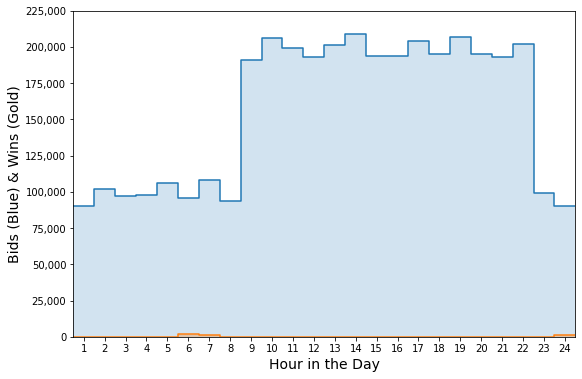

Impressions: 4,000
Budget:      $1,000.00
Win Percent: 0%
Spend:       $0.21 (0.0% Spent)
CPM:         $0.05

Conversions: 3
Revenue:     $16.24
CPA:         $0.07
ROAS:        76.76


In [ ]:
your_bid = .1

simulate_line_item(
    your_bid               = your_bid, 
    auction_type           = 'second-price',
    day_hourly_inventory   = 200,
    night_hourly_inventory = 100,
    inventory_noise        = 10,
    day_hourly_mean_bid    = 8, 
    night_hourly_mean_bid  = 4, 
    conversion_rate        = .0005,
    revenue_mean           = 5,
    revenue_std            = .5,
    budget                 = 1000
)

Based on this simulation, see if you can answer the following (knowing that we can only change our bid):
* How can we increase our ROAS? Does this make sense in the context of our campaign budget?
* If there were two line items, how could we increase ROAS?
* How can we decrease our CPM? Does this make sense in the context of campaign optimization?
* Why is our CPM different from the amount we bid? (hint: change `auction_type` in `simulate_line_item()` to "first-price")
* Try to maximize Revenue. Is this the same as maximizing ROAS? Why or why not?